In [1]:
# docker container start hfpt_July21

import time
from datetime import date

startTime = time.time()
todaysDate = date.today()

# Run Date: Thursday, August 31, 2023
# Run Time: 00:19:33

#### Start with the imports

In [2]:
import os

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
# from torchsummary import summary
from torchinfo import summary
from tqdm import tqdm

In [3]:
# only target the 2070 Super ...
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
!ls /tf/All/Data/Kaggle/Chest_X-ray_Images

test  train


In [5]:
# root folder of the data directory
dataDir = '/tf/All/Data/Kaggle/Chest_X-ray_Images'

#### Explore the data

In [6]:
# 2 types of x-rays ...
class_name = ['NORMAL','PNEUMONIA']

In [7]:
def get_list_files(dirName):
    files_list = os.listdir(dirName)
    return files_list

In [8]:
trainDir = dataDir + '/train/'
testDir = dataDir + '/test/'
print(trainDir)
print(testDir)

/tf/All/Data/Kaggle/Chest_X-ray_Images/train/
/tf/All/Data/Kaggle/Chest_X-ray_Images/test/


In [9]:
files_list_normal_train = get_list_files(trainDir + class_name[0])
files_list_pneu_train = get_list_files(trainDir + class_name[1])

In [10]:
files_list_normal_test = get_list_files(testDir + class_name[0])
files_list_pneu_test = get_list_files(testDir + class_name[1])

In [11]:
print("Number of train samples in Normal category {}".format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".format(len(files_list_pneu_train)))

Number of train samples in Normal category 1349
Number of train samples in Pneumonia category 3883


In [12]:
print("Number of test samples in Normal category {}".format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".format(len(files_list_pneu_test)))

Number of test samples in Normal category 234
Number of test samples in Pneumonia category 390


In [13]:
## get random file to check
img = dataDir + '/train/NORMAL/'+ files_list_normal_train[np.random.randint(0,len(files_list_normal_train))]
print(plt.imread(img).shape)

(1330, 1596)


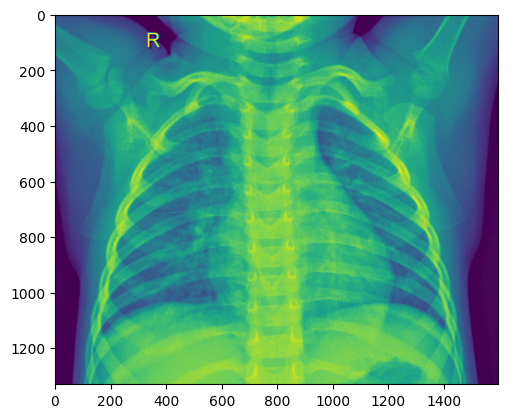

In [14]:
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(1024, 1584)


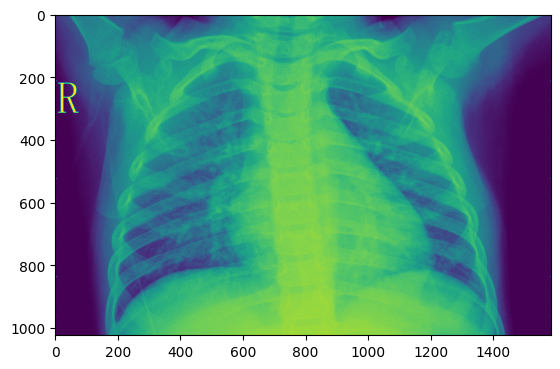

In [15]:
## get random file to check pneumona 
img = dataDir + '/train/PNEUMONIA/'+ files_list_pneu_train[np.random.randint(0,len(files_list_pneu_train))]
print(plt.imread(img).shape)
#display(Image.open(img,'r'),)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

Again, we change the transformation on the training set so that it differs from the transformation on the test set.

In [16]:
# train_transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                           [0.229, 0.224, 0.225])
# ])

train_transform = transforms.Compose([
    
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

In [17]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

In [18]:
# getting the train and test data loader in place
train_data = datasets.ImageFolder(os.path.join(dataDir, 'train'), transform=train_transform)

Again, the batch_size goes down to 4.

In [19]:
# train_loader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, pin_memory=True)

In [20]:
class_names = train_data.classes
class_names

['NORMAL', 'PNEUMONIA']

In [21]:
test_data = datasets.ImageFolder(os.path.join(dataDir, 'test'), transform=test_transform)

In [22]:
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True)

In [23]:
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

Number of train images: 5232
Number of test images: 624


#### Define the Model

We now will make some tweaks to the model. Primarily, we add a BatchNorn2d layer after every ReLU layer in every convblock.

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), 
                      padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) 
        self.pool11 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),
                      padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) 

        self.pool22 = nn.MaxPool2d(2, 2) 


        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            nn.ReLU(),
            nn.BatchNorm2d(10),
        ) 
        self.pool33 = nn.MaxPool2d(2, 2) 
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10)
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            
            nn.ReLU(),
            nn.BatchNorm2d(32),
           
        ) 


        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10)
         
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )


        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10)
            
        ) 

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14)
            
        ) 

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16)
            
        ) 
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) 

        self.convblockout = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False),

        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)        
        x = self.convblockout(x)

        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)

In [25]:
# and of course, use cuda when you can!
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
model = Net().to(device)

In [27]:
# This is blowing up, and I don't know why ... meh
# summary(model, input_size=(3, 224, 224))

In [28]:
# The first two notebooks did not have this ... !
# AND yet, it changes down below! WTF?! .. why do we have this??
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#### Training Process

In [29]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get data
        data, target = data.to(device), target.to(device)

        # Initialization of gradient
        optimizer.zero_grad()
        # In PyTorch, gradient is accumulated over backprop and even though thats used in RNN generally not used in CNN 
        # or specific requirements
        ## prediction on data
        y_pred = model(data)

        # Calculating loss given the prediction
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backprop
        loss.backward()
        optimizer.step()
        # get the index of the log-probability corresponding to the max value
        pred = y_pred.argmax(dim=1, keepdim=True)  
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_accuracies.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() 
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    test_accuracies.append(100. * correct / len(test_loader.dataset))

In [30]:
model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHS = 15

In [31]:
%%time
for epoch in range(EPOCHS):
    print("EPOCH number :", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('Current Learing Rate : ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH number : 0


Loss=0.5973320007324219 Batch_id=1307 Accuracy=90.16: 100%|██████████| 1308/1308 [01:10<00:00, 18.59it/s]    


Current Learing Rate :  0.01

Test set: Average loss: 0.6249, Accuracy: 505/624 (80.93%)

EPOCH number : 1


Loss=0.11387068033218384 Batch_id=1307 Accuracy=93.94: 100%|██████████| 1308/1308 [01:09<00:00, 18.71it/s]   


Current Learing Rate :  0.01

Test set: Average loss: 0.3388, Accuracy: 543/624 (87.02%)

EPOCH number : 2


Loss=0.0788581594824791 Batch_id=1307 Accuracy=94.17: 100%|██████████| 1308/1308 [01:09<00:00, 18.76it/s]    


Current Learing Rate :  0.01

Test set: Average loss: 0.4796, Accuracy: 512/624 (82.05%)

EPOCH number : 3


Loss=0.3894408941268921 Batch_id=1307 Accuracy=94.48: 100%|██████████| 1308/1308 [01:09<00:00, 18.74it/s]    


Current Learing Rate :  0.01

Test set: Average loss: 0.4242, Accuracy: 541/624 (86.70%)

EPOCH number : 4


Loss=0.008181910030543804 Batch_id=1307 Accuracy=95.13: 100%|██████████| 1308/1308 [01:10<00:00, 18.61it/s]  


Current Learing Rate :  0.01

Test set: Average loss: 0.3920, Accuracy: 547/624 (87.66%)

EPOCH number : 5


Loss=0.00344064156524837 Batch_id=1307 Accuracy=95.24: 100%|██████████| 1308/1308 [01:09<00:00, 18.75it/s]   


Current Learing Rate :  0.005

Test set: Average loss: 0.5241, Accuracy: 531/624 (85.10%)

EPOCH number : 6


Loss=0.04304477199912071 Batch_id=1307 Accuracy=95.81: 100%|██████████| 1308/1308 [01:10<00:00, 18.65it/s]   


Current Learing Rate :  0.005

Test set: Average loss: 0.5344, Accuracy: 523/624 (83.81%)

EPOCH number : 7


Loss=0.004243208095431328 Batch_id=1307 Accuracy=96.06: 100%|██████████| 1308/1308 [01:10<00:00, 18.57it/s]  


Current Learing Rate :  0.005

Test set: Average loss: 0.4617, Accuracy: 545/624 (87.34%)

EPOCH number : 8


Loss=0.0023622922599315643 Batch_id=1307 Accuracy=95.91: 100%|██████████| 1308/1308 [01:10<00:00, 18.65it/s] 


Current Learing Rate :  0.005

Test set: Average loss: 0.5500, Accuracy: 532/624 (85.26%)

EPOCH number : 9


Loss=0.047818586230278015 Batch_id=1307 Accuracy=96.12: 100%|██████████| 1308/1308 [01:10<00:00, 18.67it/s]  


Current Learing Rate :  0.005

Test set: Average loss: 0.5217, Accuracy: 520/624 (83.33%)

EPOCH number : 10


Loss=0.3056536316871643 Batch_id=1307 Accuracy=96.25: 100%|██████████| 1308/1308 [01:09<00:00, 18.69it/s]    


Current Learing Rate :  0.005

Test set: Average loss: 0.3677, Accuracy: 552/624 (88.46%)

EPOCH number : 11


Loss=0.00312424311414361 Batch_id=1307 Accuracy=96.27: 100%|██████████| 1308/1308 [01:10<00:00, 18.52it/s]   


Current Learing Rate :  0.0025

Test set: Average loss: 0.4928, Accuracy: 540/624 (86.54%)

EPOCH number : 12


Loss=0.041367433965206146 Batch_id=1307 Accuracy=97.06: 100%|██████████| 1308/1308 [01:12<00:00, 18.16it/s]  


Current Learing Rate :  0.0025

Test set: Average loss: 0.4794, Accuracy: 536/624 (85.90%)

EPOCH number : 13


Loss=0.005528033245354891 Batch_id=1307 Accuracy=96.81: 100%|██████████| 1308/1308 [01:11<00:00, 18.41it/s]  


Current Learing Rate :  0.0025

Test set: Average loss: 0.4488, Accuracy: 547/624 (87.66%)

EPOCH number : 14


Loss=0.00014144777378533036 Batch_id=1307 Accuracy=96.69: 100%|██████████| 1308/1308 [01:13<00:00, 17.87it/s]


Current Learing Rate :  0.0025

Test set: Average loss: 0.5044, Accuracy: 538/624 (86.22%)

CPU times: user 1h 54min 30s, sys: 19.5 s, total: 1h 54min 49s
Wall time: 19min 29s


Text(0.5, 1.0, 'Test Accuracy')

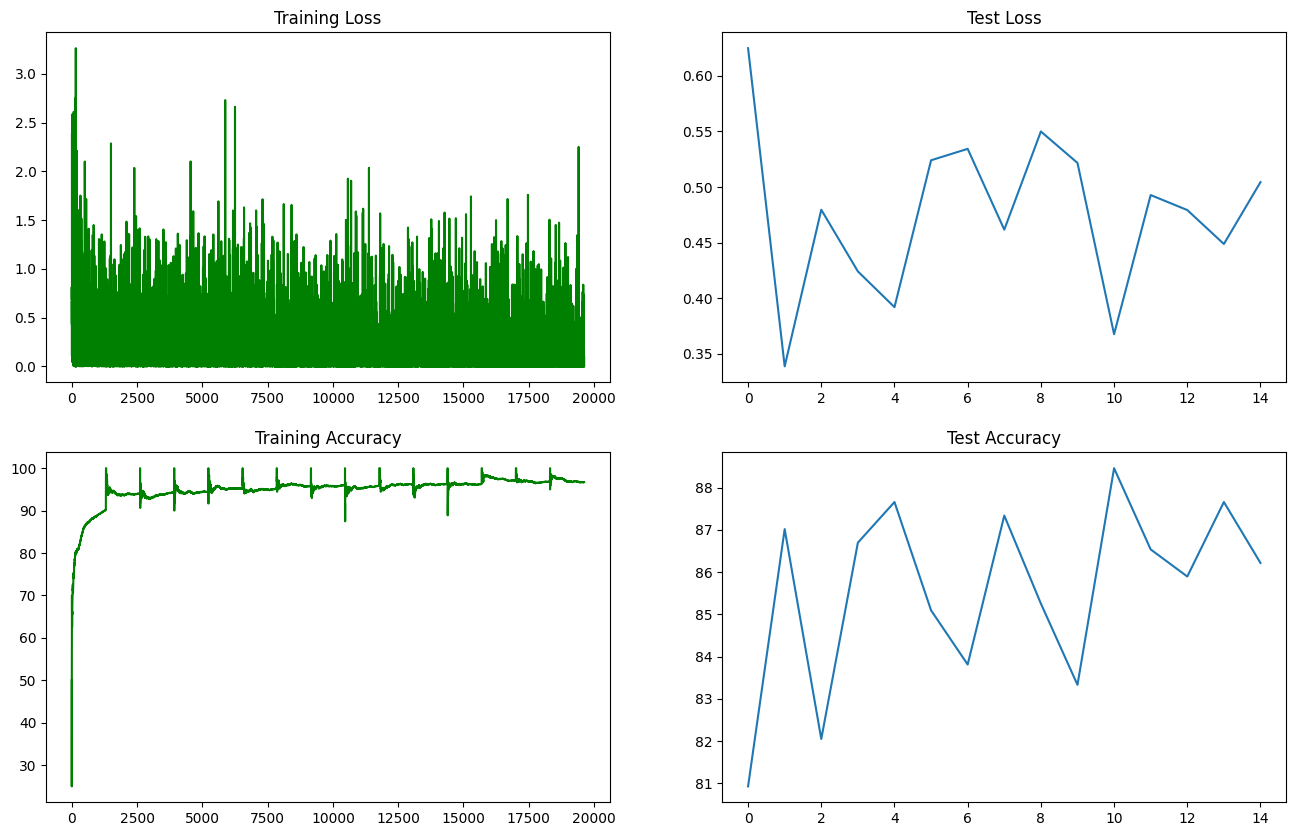

In [32]:
torch.cuda.synchronize()
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_accuracies]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_accuracies]

fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")

In [33]:
endTime = time.time()

elapsedTime = time.strftime("%H:%M:%S", time.gmtime(endTime - startTime))

print(todaysDate.strftime('# Run Date: %A, %B %d, %Y'))
print(f"# Run Time: {elapsedTime}")

# Run Date: Thursday, August 31, 2023
# Run Time: 00:19:33
